In [1]:
import tensorflow as tf
import gym
import os
import numpy as np
import random
import sys
from collections import namedtuple

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.envs.make("Berzerk-v0")

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.001)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape = shape)
    return initial

In [4]:
class state_processor():
    """
    Crop the image to proper size and stack two images into a future model input.
    """
    def __init__(self):
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape = [210, 160, 3], dtype = tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)
            
    def process(self, sess, state):
        """
        Args:
            sess: tensorflow session
            state: input image.
        Returns:
            A process [84, 84] greyscale image.
        """
        return sess.run(self.output, {self.input_state: state})

In [5]:
class state_predictor():
    """
        Build a network to predict next state.
    """
    def __init__(self, scope = "state_predictor", summary_dir = None):
        with tf.variable_scope(scope):
            self.model = self._build_model()
            self.summary_writer = None
            if summary_dir:
                summary_dir = os.path.join(summary_dir, "summarize_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
            
        
    def _build_model(self):
        """
            Build tensorflow graph.
        """
        self.x_pl = tf.placeholder(shape = [None, 84, 84, 4], dtype = tf.uint8, name = "X")
        self.y_pl = tf.placeholder(shape = [None, 7056], dtype = tf.float32, name = "Y")
        self.action_pl = tf.placeholder(shape = [None, 4], dtype = tf.float32, name = "action")
        
        X = tf.to_float(self.x_pl) / 255.0
        Y = self.y_pl / 255.0
        batch_size = tf.shape(self.x_pl)[0]
        
        #Three convolution layers:
        conv1 = tf.contrib.layers.conv2d(
            X, num_outputs = 128, kernel_size = 3, stride = 2, activation_fn = tf.nn.relu, padding = "SAME")
        conv2 = tf.contrib.layers.conv2d(
            conv1, num_outputs = 128, kernel_size = 3, stride = 2, activation_fn = tf.nn.relu, padding = "SAME")
        conv3 = tf.contrib.layers.conv2d(
            conv2, num_outputs = 128, kernel_size = 3, stride = 2, activation_fn = tf.nn.relu, padding = "SAME")
        # Add two fully connected layers.
        flattened = tf.reshape(conv3, [batch_size, 121, 128])
        rnn_input = tf.unstack(flattened, 128, 2)
        
        #Define the RNN network
        lstm_layer = tf.contrib.rnn.BasicLSTMCell(121, forget_bias = 1)
        rnn_outputs, _ = tf.contrib.rnn.static_rnn(lstm_layer, rnn_input, dtype = tf.float32)
        outputs_flattened = tf.stack(rnn_outputs, axis = 2)
        final_flattend = tf.contrib.layers.flatten(outputs_flattened)
        
        w_action = weight_variable([4, 300])
        w_enc = weight_variable([15488, 300])
        w_dec = weight_variable([300, 15488])
        b = bias_variable([15488])
            
        p1 = tf.nn.relu(tf.matmul(self.action_pl, w_action))
        p2 = tf.nn.relu(tf.matmul(final_flattend, w_enc))
        h = tf.multiply(p1, p2)
        f = tf.nn.relu(tf.matmul(h, w_dec) + b)
        d_conv = tf.reshape(f, [batch_size, 11, 11, 128])
        
        d_conv1 = tf.nn.conv2d_transpose(d_conv, filter = tf.get_variable(shape = [3, 3, 128, 128], name = "d_conv1_filter"), 
                                         output_shape = [batch_size, 21, 21, 128], strides = [1, 2, 2, 1], padding = "SAME")
        d_conv2 = tf.nn.conv2d_transpose(d_conv1, filter = tf.get_variable(shape = [3, 3, 128, 128], name = "d_conv2_filter1"), 
                                         output_shape = [batch_size, 42, 42, 128], strides = [1, 2, 2, 1], padding = "SAME")
        d_conv3 = tf.nn.conv2d_transpose(d_conv2, filter = tf.get_variable(shape = [3, 3, 1, 128], name = "d_conv3_filter1"), 
                                         output_shape = [batch_size, 84, 84, 1], strides = [1, 2, 2, 1], padding = "SAME")
        
        self.predictions = tf.reshape(d_conv3, [batch_size, 7056])
        self.losses = tf.squared_difference(Y, self.predictions)
        #losses = tf.subtract(self.y_pl, predictions)
        self.loss = tf.reduce_mean(self.losses)
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = 0.0005)
        self.train_op = self.optimizer.minimize(self.loss)
        
        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss)
        ])
        
        
    def predict(self, sess, x, action):
        """
        Predict next state.
        Args:
            sess: Default Tensorflow session.
            x: image with shape [batch_size, 2, 84, 84]
            action: action taken by agent with [batch_size, 4]
        """
        return sess.run(self.predictions, {self.x_pl: x, self.action_pl: action})
    
    def update(self, sess, x, y, action):
        """
        Update parameters in tensorflow graph.
        Args:
            sess: Default Tensorflow session.
            x: image with shape [batch_size, 2, 84, 84]
            y: next state with shape [batch_size, 7056]
            action: action taken by agent with [batch_size, 4]
        """
        feed_dict = { self.x_pl: x, self.y_pl: y, self.action_pl: action }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [6]:
def action_value(action):
    lens = action.shape[0]
    sv = np.zeros((lens, 4))
    sv[np.array([i for i in range(lens)]),action.squeeze()] = 1
    return sv

def predict_test(sp, sc, sess, batch_size = 16, memory_size=30000, training_times = 10):
    """
    Test function for state predictor.
    
    Args:
        sp: state_predictor
        rp: reward_predictor
        sc: state_processor
    """
    
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    
    #Populating memory
    print("Populating Replay Memory")
    memory = []
    state = env.reset()
    state = sc.process(sess, state)
    state = np.stack([state] * 4, 2)
    for i in range(memory_size):
        action = np.random.choice(4, 1)
        next_state, reward, done, _ = env.step(action)
        next_state = sc.process(sess, next_state)
        next_state= np.append(state[:, :, 1:], np.expand_dims(next_state, 2), axis = 2)
        memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = sc.process(sess, state)
            state = np.stack([state] * 4, 2)
        else:
            state = next_state
    
    print("Training State Predictor Network")
    for j in range(training_times):
        samples = random.sample(memory, batch_size)
        input_states, action, reward, output_state, done = map(np.array, zip(*samples))
        
        #input_state = [sample[0] for sample in samples]
        output_states = output_state[:,:,:,3].reshape(batch_size, 7056)
        actions = action_value(action)
        #input_states = np.array(input_state)
        #output_states = np.array(output_state)
        #actions = np.array(action)
        loss = sp.update(sess, input_states, output_states, actions)
        #p = sp.predict(sess, input_states, actions)
        print("\rStep {} ({}), loss: {}".format(j, training_times, loss), end="")
        sys.stdout.flush()
        if j % 100 == 0:
            saver.save(tf.get_default_session(), checkpoint_path)
    return loss
    #return input_states, output_states, actions

In [8]:
tf.reset_default_graph()

experiment_dir = os.path.abspath("./rnn_experiments/{}".format(env.spec.id))

global_step = tf.Variable(0, name = "global_step", trainable = False)
print("Initialize processor...")
processor = state_processor()

print("Initialize predictor")
sp = state_predictor()

print("Run Session")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #input_states, output_state, action = predict_test(sp, processor, sess, memory_size= 10, training_times = 1)
    p = predict_test(sp, processor, sess, memory_size= 10000, training_times = 1000)

Initialize processor...
Initialize predictor
Run Session
Populating Replay Memory
Training State Predictor Network
Instructions for updating:
Please switch to tf.train.get_global_step
Step 999 (1000), loss: 0.003121039131656289

In [51]:
## Make Predictions Using Model

experiment_dir = os.path.abspath("./rnn_experiments/{}".format(env.spec.id))
checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

tf.reset_default_graph()
sc = state_processor()
sp = state_predictor()

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, latest_checkpoint)
    memory = []
    state = env.reset()
    state = sc.process(sess, state)
    state = np.stack([state] * 4, 2)
    for i in range(300):
        action = np.random.choice(4, 1)
        next_state, reward, done, _ = env.step(action)
        next_state = sc.process(sess, next_state)
        next_state= np.append(state[:, :, 1:], np.expand_dims(next_state, 2), axis = 2)
        memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = sc.process(sess, state)
            state = np.stack([state] * 4, 2)
        else:
            state = next_state
            
    samples = random.sample(memory, 1)
    input_states, action, reward, output_state, done = map(np.array, zip(*samples))
        
    output_states = output_state[:,:,:,3].reshape(1, 7056)
    actions = action_value(action)
    
    image = sp.predict(sess, input_states, actions)

INFO:tensorflow:Restoring parameters from /home/ds/mnt/rnn_experiments/Berzerk-v0/checkpoints/model


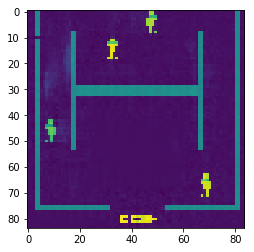

In [52]:
from matplotlib import pyplot as plt
plt.imshow(image.reshape([84,84]), interpolation='nearest')
plt.show()

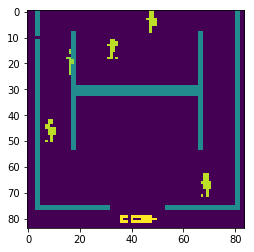

In [53]:
plt.imshow(np.squeeze(output_state[:,:,:,3]), interpolation='nearest')
plt.show()